This notebook show the steps of training and evaluation of Smile Detect Model.\
The model will training using CNN (Convention Neural Network) framework using Keras.\
The dataset using is GENKI-4K public version open source by Institute for Neural Computation (INC) from University of California San Diego.

[Source of GENKI-4K image dataset](https://inc.ucsd.edu/mplab/398/)\
GENKI-4K research paper => DOI: 10.1109/FG.2018.00107

In [144]:
!nvidia-smi

Sun Apr  9 12:01:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0A:00.0 Off |                  N/A |
| 75%   79C    P2   349W / 350W |  23444MiB / 24576MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# Check machine able to use GPU or not
# If not, use the CPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2023-04-09 12:02:22.008939: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14314025020606800887
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 722468864
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17563641805875955671
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0a:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-04-09 12:02:23.228336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-09 12:02:23.231581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-09 12:02:23.231706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
# keras - neural network
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import tensorflow as tf

# python imports
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from IPython.display import clear_output

# CV2 image process
import cv2

In [4]:
from os import listdir
from os.path import isfile, join

In [5]:
img_size = 24

In [46]:
def get_data(data_dir):
    data_train = []
    data_val = []
    
    for x in listdir(data_dir + "/" + "train/open"):
        path = data_dir + "/" + "train/open/" + x
        if path.endswith(".jpg") == False:
            continue
        img = cv2.imread(path)
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        data_train.append([img, 0])
        
    for x in listdir(data_dir + "/" + "train/closed"):
        path = data_dir + "/" + "train/closed/" + x
        if path.endswith(".jpg") == False:
            continue
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        data_train.append([img, 1])
        
    for x in listdir(data_dir + "/" + "val/open"):
        path = data_dir + "/" + "val/open/" + x
        if path.endswith(".jpg") == False:
            continue
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        data_val.append([img, 0])
        
    for x in listdir(data_dir + "/" + "val/closed"):
        path = data_dir + "/" + "val/closed/" + x
        if path.endswith(".jpg") == False:
            continue
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        data_val.append([img, 1])
        
    return np.array(data_train), np.array(data_val)

In [47]:
# directory of GENKI-4K dataset
image_file_path = "dataset"
train, test = get_data(image_file_path)

/tmp/ipykernel_34245/3205906513.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_train), np.array(data_val)


In [48]:
train[0][0].shape

(24, 24)

Check None In Dataset

In [49]:
# Original Train, Test data samples
print("Train Dataset: " + str(len(train)))
print("Test Dataset: " + str(len(test)))

Train Dataset: 3780
Test Dataset: 1068


In [50]:
import pandas as pd

df_train = pd.DataFrame(train, columns = ['Image_Array','Label'])

df_test = pd.DataFrame(test, columns = ['Image_Array','Label'])

In [51]:
df_train

,Image_Array,Label
0,"[[164, 174, 171, 156, 150, 152, 141, 123, 106,...",0
1,"[[135, 136, 138, 138, 138, 140, 143, 145, 150,...",0
2,"[[136, 138, 142, 150, 160, 169, 175, 178, 188,...",0
3,"[[88, 91, 95, 101, 106, 108, 107, 106, 96, 89,...",0
4,"[[134, 138, 144, 149, 152, 153, 154, 155, 158,...",0
...,...,...
3775,"[[183, 195, 209, 217, 218, 219, 223, 228, 233,...",1
3776,"[[97, 101, 120, 147, 164, 167, 171, 178, 182, ...",1
3777,"[[97, 103, 113, 122, 125, 127, 136, 147, 149, ...",1
3778,"[[96, 96, 103, 112, 112, 106, 111, 122, 112, 1...",1


In [52]:
df_test

,Image_Array,Label
0,"[[94, 95, 95, 96, 96, 97, 97, 97, 91, 88, 86, ...",0
1,"[[166, 158, 152, 152, 153, 151, 149, 149, 147,...",0
2,"[[85, 86, 85, 83, 81, 80, 81, 83, 95, 92, 88, ...",0
3,"[[131, 123, 115, 111, 111, 108, 100, 93, 88, 8...",0
4,"[[135, 135, 141, 147, 146, 140, 141, 148, 156,...",0
...,...,...
1063,"[[4, 5, 6, 6, 5, 5, 7, 9, 15, 14, 16, 22, 22, ...",1
1064,"[[154, 167, 178, 181, 185, 191, 193, 191, 192,...",1
1065,"[[92, 93, 96, 100, 105, 111, 115, 118, 129, 13...",1
1066,"[[136, 140, 138, 132, 128, 126, 118, 107, 100,...",1


In [53]:
# drop image row if there's no image array in it
df_train = df_train.mask(df_train.eq('None')).dropna()
df_test = df_test.mask(df_test.eq('None')).dropna()

/usr/local/lib/python3.8/dist-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)
/usr/local/lib/python3.8/dist-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [54]:
df_train

,Image_Array,Label
0,"[[164, 174, 171, 156, 150, 152, 141, 123, 106,...",0
1,"[[135, 136, 138, 138, 138, 140, 143, 145, 150,...",0
2,"[[136, 138, 142, 150, 160, 169, 175, 178, 188,...",0
3,"[[88, 91, 95, 101, 106, 108, 107, 106, 96, 89,...",0
4,"[[134, 138, 144, 149, 152, 153, 154, 155, 158,...",0
...,...,...
3775,"[[183, 195, 209, 217, 218, 219, 223, 228, 233,...",1
3776,"[[97, 101, 120, 147, 164, 167, 171, 178, 182, ...",1
3777,"[[97, 103, 113, 122, 125, 127, 136, 147, 149, ...",1
3778,"[[96, 96, 103, 112, 112, 106, 111, 122, 112, 1...",1


In [55]:
df_test

,Image_Array,Label
0,"[[94, 95, 95, 96, 96, 97, 97, 97, 91, 88, 86, ...",0
1,"[[166, 158, 152, 152, 153, 151, 149, 149, 147,...",0
2,"[[85, 86, 85, 83, 81, 80, 81, 83, 95, 92, 88, ...",0
3,"[[131, 123, 115, 111, 111, 108, 100, 93, 88, 8...",0
4,"[[135, 135, 141, 147, 146, 140, 141, 148, 156,...",0
...,...,...
1063,"[[4, 5, 6, 6, 5, 5, 7, 9, 15, 14, 16, 22, 22, ...",1
1064,"[[154, 167, 178, 181, 185, 191, 193, 191, 192,...",1
1065,"[[92, 93, 96, 100, 105, 111, 115, 118, 129, 13...",1
1066,"[[136, 140, 138, 132, 128, 126, 118, 107, 100,...",1


In [56]:
train = df_train.to_numpy()
test = df_test.to_numpy()

In [57]:
train[0][0]

array([[164, 174, 171, 156, 150, 152, 141, 123, 106,  91,  74,  63,  54,
         47,  45,  46,  56,  76,  88,  82,  73,  72,  69,  63],
       [165, 168, 161, 145, 131, 121, 104,  86,  71,  62,  54,  55,  58,
         62,  68,  74,  94, 105, 109, 101,  95,  91,  82,  69],
       [158, 152, 141, 127, 109,  88,  69,  57,  55,  53,  57,  70,  85,
         97, 109, 119, 128, 129, 125, 118, 115, 112,  97,  79],
       [145, 132, 119, 111,  95,  74,  61,  58,  65,  67,  78,  95, 110,
        120, 130, 137, 132, 131, 126, 122, 122, 119, 105,  90],
       [134, 117, 103,  97,  87,  72,  67,  72,  75,  79,  89, 103, 111,
        113, 115, 119, 121, 122, 123, 121, 121, 117, 108,  98],
       [124, 108,  93,  86,  80,  74,  76,  83,  91,  93,  99, 105, 106,
        102, 101, 104, 114, 117, 121, 122, 120, 115, 108, 103],
       [106,  97,  85,  79,  79,  83,  90,  95, 109, 106, 105, 105, 101,
         96,  98, 103, 108, 109, 114, 120, 121, 115, 107, 101],
       [ 89,  85,  79,  76,  82,  94, 104

In [58]:
# Train, Test dataset after dropna
print("Train Dataset: " + str(len(train)))
print("Test Dataset: " + str(len(test)))

Train Dataset: 3780
Test Dataset: 1068


Test Image

In [59]:
train[1][0].shape

(24, 24)

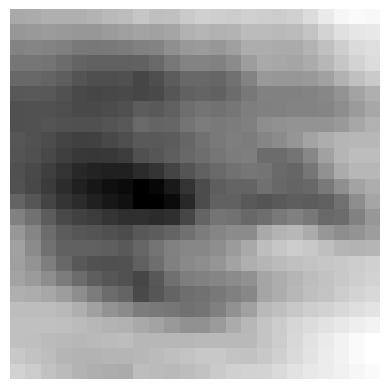

In [60]:
from PIL import Image
plt.axis('off')
plt.imshow(Image.fromarray(train[1][0]), cmap='gray')

Data Distrubution

In [61]:
print("Train: " + str(len(train)) + "\nTest: " + str(len(test)))

Train: 3780
Test: 1068


Check distribution of smile, non-smile image between two set

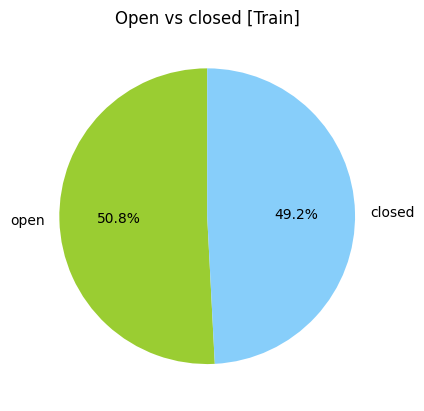

In [62]:
data = []
for i in train:
    if(i[1] == 1):
        data.append('closed')
    else:
        data.append('open')

# Calculate the total count for each category
open_count = data.count('open')
closed_count = data.count('closed')
count_data = [open_count, closed_count]

# Define the labels for the pie chart
labels = ['open', 'closed']

# Define the colors for the pie chart
colors = ['yellowgreen', 'lightskyblue']

# Create the pie chart
plt.pie(count_data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Add the title to the plot
plt.title('Open vs closed [Train]')

# Show the plot
plt.show()

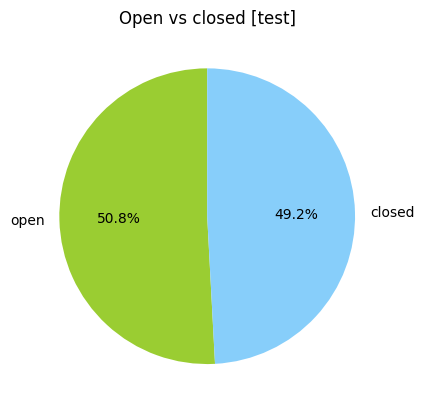

In [63]:
data = []
for i in test:
    if(i[1] == 1):
        data.append('closed')
    else:
        data.append('open')

# Calculate the total count for each category
open_count = data.count('open')
closed_count = data.count('closed')
count_data = [open_count, closed_count]

# Define the labels for the pie chart
labels = ['open', 'closed']

# Define the colors for the pie chart
colors = ['yellowgreen', 'lightskyblue']

# Create the pie chart
plt.pie(count_data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Add the title to the plot
plt.title('Open vs closed [test]')

# Show the plot
plt.show()

Split the features and label

In [64]:
train[755][0].shape

(24, 24)

In [65]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_val.append(feature)
    y_val.append(label)

# Convert the grayscale images to RGB images
x_train_3d = []
x_val_3d = []

for gray_image in x_train:
    # Convert the grayscale image to a 3D array by repeating the grayscale channel three times
    rgb_image = np.repeat(np.expand_dims(gray_image, axis=2), 3, axis=2)
    x_train_3d.append(rgb_image)

for gray_image in x_val:
    # Convert the grayscale image to a 3D array by repeating the grayscale channel three times
    rgb_image = np.repeat(np.expand_dims(gray_image, axis=2), 3, axis=2)
    x_val_3d.append(rgb_image)

x_train = np.array(x_train_3d)
x_val = np.array(x_val_3d)
    
# Normalize the data
x_train = x_train / 255
x_val = x_val / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [66]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

### Neural Network

In [67]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size,img_size,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))

# two output
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

2023-04-09 12:15:11.545121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-09 12:15:11.545317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-09 12:15:11.545464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [68]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 20, start_from_epoch = 800, verbose = 1)
opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [69]:
history = model.fit(x_train,y_train,epochs = 1200 , validation_data = (x_val, y_val), callbacks=[early_stopping])

Epoch 1/1200


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-04-09 12:15:15.967051: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-09 12:15:19.348307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-09 12:15:24.859670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


119/119 [==============================] - 18s 45ms/step - loss: 0.6949 - accuracy: 0.5008 - val_loss: 0.6926 - val_accuracy: 0.5103
Epoch 2/1200
119/119 [==============================] - 2s 15ms/step - loss: 0.6942 - accuracy: 0.5058 - val_loss: 0.6920 - val_accuracy: 0.5140
Epoch 3/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.6936 - accuracy: 0.5217 - val_loss: 0.6915 - val_accuracy: 0.5824
Epoch 4/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.6918 - accuracy: 0.5267 - val_loss: 0.6910 - val_accuracy: 0.6086
Epoch 5/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.6922 - accuracy: 0.5183 - val_loss: 0.6905 - val_accuracy: 0.6086
Epoch 6/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.6923 - accuracy: 0.5230 - val_loss: 0.6901 - val_accuracy: 0.5871
Epoch 7/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.6918 - accuracy: 0.5209 - val_loss: 0.6897 - val_accuracy: 0.56

119/119 [==============================] - 2s 16ms/step - loss: 0.6744 - accuracy: 0.6220 - val_loss: 0.6724 - val_accuracy: 0.6067
Epoch 58/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.6752 - accuracy: 0.6071 - val_loss: 0.6720 - val_accuracy: 0.6105
Epoch 59/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.6762 - accuracy: 0.6066 - val_loss: 0.6714 - val_accuracy: 0.6189
Epoch 60/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.6747 - accuracy: 0.6317 - val_loss: 0.6710 - val_accuracy: 0.6217
Epoch 61/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.6734 - accuracy: 0.6286 - val_loss: 0.6705 - val_accuracy: 0.6264
Epoch 62/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.6751 - accuracy: 0.6132 - val_loss: 0.6700 - val_accuracy: 0.6283
Epoch 63/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.6726 - accuracy: 0.6310 - val_loss: 0.6695 - val_accuracy:

119/119 [==============================] - 1s 4ms/step - loss: 0.6425 - accuracy: 0.7151 - val_loss: 0.6320 - val_accuracy: 0.7500
Epoch 114/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.6407 - accuracy: 0.7265 - val_loss: 0.6310 - val_accuracy: 0.7500
Epoch 115/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.6398 - accuracy: 0.7095 - val_loss: 0.6300 - val_accuracy: 0.7491
Epoch 116/1200
119/119 [==============================] - 1s 4ms/step - loss: 0.6386 - accuracy: 0.7243 - val_loss: 0.6290 - val_accuracy: 0.7481
Epoch 117/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.6360 - accuracy: 0.7243 - val_loss: 0.6280 - val_accuracy: 0.7547
Epoch 118/1200
119/119 [==============================] - 1s 7ms/step - loss: 0.6379 - accuracy: 0.7283 - val_loss: 0.6270 - val_accuracy: 0.7547
Epoch 119/1200
119/119 [==============================] - 1s 9ms/step - loss: 0.6375 - accuracy: 0.7164 - val_loss: 0.6260 - val_accuracy: 

Epoch 169/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.5863 - accuracy: 0.7603 - val_loss: 0.5722 - val_accuracy: 0.7687
Epoch 170/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.5846 - accuracy: 0.7566 - val_loss: 0.5711 - val_accuracy: 0.7725
Epoch 171/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.5850 - accuracy: 0.7561 - val_loss: 0.5699 - val_accuracy: 0.7687
Epoch 172/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.5840 - accuracy: 0.7622 - val_loss: 0.5688 - val_accuracy: 0.7687
Epoch 173/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.5818 - accuracy: 0.7601 - val_loss: 0.5676 - val_accuracy: 0.7697
Epoch 174/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.5833 - accuracy: 0.7616 - val_loss: 0.5665 - val_accuracy: 0.7697
Epoch 175/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.5826 - accuracy: 0.7534 - val_loss: 0

Epoch 225/1200
119/119 [==============================] - 1s 12ms/step - loss: 0.5300 - accuracy: 0.7749 - val_loss: 0.5153 - val_accuracy: 0.7781
Epoch 226/1200
119/119 [==============================] - 2s 13ms/step - loss: 0.5280 - accuracy: 0.7815 - val_loss: 0.5144 - val_accuracy: 0.7781
Epoch 227/1200
119/119 [==============================] - 1s 12ms/step - loss: 0.5276 - accuracy: 0.7802 - val_loss: 0.5135 - val_accuracy: 0.7800
Epoch 228/1200
119/119 [==============================] - 0s 4ms/step - loss: 0.5244 - accuracy: 0.7854 - val_loss: 0.5127 - val_accuracy: 0.7790
Epoch 229/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.5276 - accuracy: 0.7759 - val_loss: 0.5118 - val_accuracy: 0.7790
Epoch 230/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.5249 - accuracy: 0.7847 - val_loss: 0.5110 - val_accuracy: 0.7809
Epoch 231/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.5215 - accuracy: 0.7783 - val_loss: 0.510

119/119 [==============================] - 2s 16ms/step - loss: 0.4880 - accuracy: 0.7876 - val_loss: 0.4743 - val_accuracy: 0.7921
Epoch 282/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.4891 - accuracy: 0.7857 - val_loss: 0.4737 - val_accuracy: 0.7931
Epoch 283/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.4842 - accuracy: 0.7960 - val_loss: 0.4732 - val_accuracy: 0.7949
Epoch 284/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.4878 - accuracy: 0.7897 - val_loss: 0.4726 - val_accuracy: 0.7921
Epoch 285/1200
119/119 [==============================] - 2s 15ms/step - loss: 0.4832 - accuracy: 0.7934 - val_loss: 0.4720 - val_accuracy: 0.7921
Epoch 286/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.4884 - accuracy: 0.7939 - val_loss: 0.4714 - val_accuracy: 0.7921
Epoch 287/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.4834 - accuracy: 0.7862 - val_loss: 0.4708 - val_acc

Epoch 337/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.4570 - accuracy: 0.8013 - val_loss: 0.4444 - val_accuracy: 0.8024
Epoch 338/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.4539 - accuracy: 0.8130 - val_loss: 0.4440 - val_accuracy: 0.8034
Epoch 339/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.4529 - accuracy: 0.8032 - val_loss: 0.4435 - val_accuracy: 0.8034
Epoch 340/1200
119/119 [==============================] - 2s 15ms/step - loss: 0.4545 - accuracy: 0.8026 - val_loss: 0.4430 - val_accuracy: 0.8034
Epoch 341/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.4543 - accuracy: 0.8048 - val_loss: 0.4426 - val_accuracy: 0.8034
Epoch 342/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.4503 - accuracy: 0.8103 - val_loss: 0.4420 - val_accuracy: 0.8024
Epoch 343/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.4489 - accuracy: 0.8048 - val_loss: 0

Epoch 393/1200
119/119 [==============================] - 1s 6ms/step - loss: 0.4273 - accuracy: 0.8238 - val_loss: 0.4192 - val_accuracy: 0.8137
Epoch 394/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.4288 - accuracy: 0.8190 - val_loss: 0.4189 - val_accuracy: 0.8165
Epoch 395/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.4239 - accuracy: 0.8233 - val_loss: 0.4185 - val_accuracy: 0.8165
Epoch 396/1200
119/119 [==============================] - 1s 6ms/step - loss: 0.4267 - accuracy: 0.8183 - val_loss: 0.4180 - val_accuracy: 0.8155
Epoch 397/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.4304 - accuracy: 0.8148 - val_loss: 0.4180 - val_accuracy: 0.8174
Epoch 398/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.4256 - accuracy: 0.8204 - val_loss: 0.4173 - val_accuracy: 0.8155
Epoch 399/1200
119/119 [==============================] - 1s 6ms/step - loss: 0.4286 - accuracy: 0.8167 - val_loss: 0.4169 -

119/119 [==============================] - 2s 18ms/step - loss: 0.4056 - accuracy: 0.8275 - val_loss: 0.3973 - val_accuracy: 0.8296
Epoch 450/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.4073 - accuracy: 0.8304 - val_loss: 0.3970 - val_accuracy: 0.8296
Epoch 451/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.4020 - accuracy: 0.8328 - val_loss: 0.3968 - val_accuracy: 0.8315
Epoch 452/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.4052 - accuracy: 0.8280 - val_loss: 0.3965 - val_accuracy: 0.8324
Epoch 453/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.4054 - accuracy: 0.8291 - val_loss: 0.3959 - val_accuracy: 0.8324
Epoch 454/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.4043 - accuracy: 0.8317 - val_loss: 0.3956 - val_accuracy: 0.8315
Epoch 455/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.4049 - accuracy: 0.8275 - val_loss: 0.3954 - val_acc

Epoch 505/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.3857 - accuracy: 0.8354 - val_loss: 0.3775 - val_accuracy: 0.8427
Epoch 506/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.3804 - accuracy: 0.8455 - val_loss: 0.3772 - val_accuracy: 0.8446
Epoch 507/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.3846 - accuracy: 0.8452 - val_loss: 0.3769 - val_accuracy: 0.8436
Epoch 508/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.3831 - accuracy: 0.8463 - val_loss: 0.3766 - val_accuracy: 0.8446
Epoch 509/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.3834 - accuracy: 0.8442 - val_loss: 0.3763 - val_accuracy: 0.8455
Epoch 510/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.3798 - accuracy: 0.8373 - val_loss: 0.3759 - val_accuracy: 0.8446
Epoch 511/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.3831 - accuracy: 0.8394 - val_loss: 0

Epoch 561/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.3606 - accuracy: 0.8521 - val_loss: 0.3593 - val_accuracy: 0.8577
Epoch 562/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.3650 - accuracy: 0.8489 - val_loss: 0.3587 - val_accuracy: 0.8558
Epoch 563/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.3611 - accuracy: 0.8521 - val_loss: 0.3586 - val_accuracy: 0.8567
Epoch 564/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.3610 - accuracy: 0.8566 - val_loss: 0.3582 - val_accuracy: 0.8567
Epoch 565/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.3628 - accuracy: 0.8516 - val_loss: 0.3579 - val_accuracy: 0.8567
Epoch 566/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.3650 - accuracy: 0.8505 - val_loss: 0.3576 - val_accuracy: 0.8577
Epoch 567/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.3624 - accuracy: 0.8505 - val_loss: 0.3572 -

Epoch 617/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.3447 - accuracy: 0.8661 - val_loss: 0.3418 - val_accuracy: 0.8670
Epoch 618/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.3474 - accuracy: 0.8624 - val_loss: 0.3413 - val_accuracy: 0.8680
Epoch 619/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.3458 - accuracy: 0.8640 - val_loss: 0.3410 - val_accuracy: 0.8680
Epoch 620/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.3380 - accuracy: 0.8677 - val_loss: 0.3407 - val_accuracy: 0.8680
Epoch 621/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.3424 - accuracy: 0.8672 - val_loss: 0.3404 - val_accuracy: 0.8689
Epoch 622/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.3445 - accuracy: 0.8622 - val_loss: 0.3402 - val_accuracy: 0.8699
Epoch 623/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.3400 - accuracy: 0.8632 - val_loss: 0

Epoch 673/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.3323 - accuracy: 0.8667 - val_loss: 0.3243 - val_accuracy: 0.8830
Epoch 674/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.3296 - accuracy: 0.8749 - val_loss: 0.3242 - val_accuracy: 0.8830
Epoch 675/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.3300 - accuracy: 0.8698 - val_loss: 0.3237 - val_accuracy: 0.8830
Epoch 676/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.3287 - accuracy: 0.8741 - val_loss: 0.3236 - val_accuracy: 0.8830
Epoch 677/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.3307 - accuracy: 0.8706 - val_loss: 0.3234 - val_accuracy: 0.8820
Epoch 678/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.3267 - accuracy: 0.8765 - val_loss: 0.3229 - val_accuracy: 0.8839
Epoch 679/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.3296 - accuracy: 0.8709 - val_loss: 0

Epoch 729/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.3066 - accuracy: 0.8794 - val_loss: 0.3079 - val_accuracy: 0.8914
Epoch 730/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.3088 - accuracy: 0.8892 - val_loss: 0.3076 - val_accuracy: 0.8914
Epoch 731/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.3100 - accuracy: 0.8823 - val_loss: 0.3072 - val_accuracy: 0.8895
Epoch 732/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.3083 - accuracy: 0.8828 - val_loss: 0.3070 - val_accuracy: 0.8886
Epoch 733/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.3071 - accuracy: 0.8849 - val_loss: 0.3066 - val_accuracy: 0.8886
Epoch 734/1200
119/119 [==============================] - 1s 6ms/step - loss: 0.3058 - accuracy: 0.8873 - val_loss: 0.3064 - val_accuracy: 0.8886
Epoch 735/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.3069 - accuracy: 0.8870 - val_loss: 0.3060 -

Epoch 785/1200
119/119 [==============================] - 2s 15ms/step - loss: 0.2915 - accuracy: 0.8915 - val_loss: 0.2923 - val_accuracy: 0.8979
Epoch 786/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.2928 - accuracy: 0.8884 - val_loss: 0.2921 - val_accuracy: 0.8970
Epoch 787/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.2876 - accuracy: 0.8934 - val_loss: 0.2919 - val_accuracy: 0.8961
Epoch 788/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.2908 - accuracy: 0.8910 - val_loss: 0.2915 - val_accuracy: 0.8961
Epoch 789/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.2950 - accuracy: 0.8902 - val_loss: 0.2913 - val_accuracy: 0.8961
Epoch 790/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.2926 - accuracy: 0.8918 - val_loss: 0.2910 - val_accuracy: 0.8989
Epoch 791/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2916 - accuracy: 0.8881 - val_loss: 0

Epoch 841/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.2753 - accuracy: 0.9011 - val_loss: 0.2779 - val_accuracy: 0.9017
Epoch 842/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.2772 - accuracy: 0.8989 - val_loss: 0.2777 - val_accuracy: 0.9026
Epoch 843/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2800 - accuracy: 0.9003 - val_loss: 0.2774 - val_accuracy: 0.9026
Epoch 844/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2763 - accuracy: 0.8960 - val_loss: 0.2771 - val_accuracy: 0.9017
Epoch 845/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2765 - accuracy: 0.9008 - val_loss: 0.2769 - val_accuracy: 0.9026
Epoch 846/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2806 - accuracy: 0.8950 - val_loss: 0.2767 - val_accuracy: 0.9026
Epoch 847/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2764 - accuracy: 0.8976 - val_loss: 0

119/119 [==============================] - 1s 5ms/step - loss: 0.2664 - accuracy: 0.9032 - val_loss: 0.2644 - val_accuracy: 0.9064
Epoch 898/1200
119/119 [==============================] - 1s 6ms/step - loss: 0.2655 - accuracy: 0.9040 - val_loss: 0.2642 - val_accuracy: 0.9064
Epoch 899/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.2623 - accuracy: 0.9026 - val_loss: 0.2639 - val_accuracy: 0.9064
Epoch 900/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.2657 - accuracy: 0.8958 - val_loss: 0.2638 - val_accuracy: 0.9073
Epoch 901/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.2622 - accuracy: 0.9029 - val_loss: 0.2635 - val_accuracy: 0.9064
Epoch 902/1200
119/119 [==============================] - 0s 4ms/step - loss: 0.2619 - accuracy: 0.9026 - val_loss: 0.2632 - val_accuracy: 0.9073
Epoch 903/1200
119/119 [==============================] - 0s 4ms/step - loss: 0.2644 - accuracy: 0.9069 - val_loss: 0.2630 - val_accuracy: 

Epoch 953/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2544 - accuracy: 0.9085 - val_loss: 0.2519 - val_accuracy: 0.9120
Epoch 954/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.2545 - accuracy: 0.9082 - val_loss: 0.2517 - val_accuracy: 0.9110
Epoch 955/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.2525 - accuracy: 0.9146 - val_loss: 0.2514 - val_accuracy: 0.9101
Epoch 956/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2519 - accuracy: 0.9082 - val_loss: 0.2513 - val_accuracy: 0.9101
Epoch 957/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.2514 - accuracy: 0.9071 - val_loss: 0.2511 - val_accuracy: 0.9101
Epoch 958/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.2484 - accuracy: 0.9114 - val_loss: 0.2510 - val_accuracy: 0.9110
Epoch 959/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2507 - accuracy: 0.9116 - val_loss: 0

119/119 [==============================] - 2s 18ms/step - loss: 0.2405 - accuracy: 0.9119 - val_loss: 0.2409 - val_accuracy: 0.9157
Epoch 1009/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2409 - accuracy: 0.9153 - val_loss: 0.2404 - val_accuracy: 0.9139
Epoch 1010/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.2384 - accuracy: 0.9188 - val_loss: 0.2402 - val_accuracy: 0.9129
Epoch 1011/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.2401 - accuracy: 0.9124 - val_loss: 0.2400 - val_accuracy: 0.9129
Epoch 1012/1200
119/119 [==============================] - 1s 12ms/step - loss: 0.2393 - accuracy: 0.9161 - val_loss: 0.2399 - val_accuracy: 0.9139
Epoch 1013/1200
119/119 [==============================] - 1s 4ms/step - loss: 0.2374 - accuracy: 0.9153 - val_loss: 0.2396 - val_accuracy: 0.9148
Epoch 1014/1200
119/119 [==============================] - 0s 4ms/step - loss: 0.2387 - accuracy: 0.9130 - val_loss: 0.2394 - val

Epoch 1064/1200
119/119 [==============================] - 1s 7ms/step - loss: 0.2317 - accuracy: 0.9135 - val_loss: 0.2299 - val_accuracy: 0.9176
Epoch 1065/1200
119/119 [==============================] - 2s 15ms/step - loss: 0.2287 - accuracy: 0.9177 - val_loss: 0.2296 - val_accuracy: 0.9185
Epoch 1066/1200
119/119 [==============================] - 2s 16ms/step - loss: 0.2246 - accuracy: 0.9175 - val_loss: 0.2295 - val_accuracy: 0.9185
Epoch 1067/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2319 - accuracy: 0.9146 - val_loss: 0.2293 - val_accuracy: 0.9176
Epoch 1068/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2322 - accuracy: 0.9138 - val_loss: 0.2291 - val_accuracy: 0.9185
Epoch 1069/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2248 - accuracy: 0.9230 - val_loss: 0.2290 - val_accuracy: 0.9185
Epoch 1070/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2241 - accuracy: 0.9217 - val_l

119/119 [==============================] - 2s 17ms/step - loss: 0.2190 - accuracy: 0.9222 - val_loss: 0.2204 - val_accuracy: 0.9223
Epoch 1120/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2190 - accuracy: 0.9220 - val_loss: 0.2202 - val_accuracy: 0.9213
Epoch 1121/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.2178 - accuracy: 0.9265 - val_loss: 0.2201 - val_accuracy: 0.9223
Epoch 1122/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2189 - accuracy: 0.9196 - val_loss: 0.2200 - val_accuracy: 0.9204
Epoch 1123/1200
119/119 [==============================] - 2s 18ms/step - loss: 0.2197 - accuracy: 0.9246 - val_loss: 0.2198 - val_accuracy: 0.9232
Epoch 1124/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2165 - accuracy: 0.9225 - val_loss: 0.2196 - val_accuracy: 0.9223
Epoch 1125/1200
119/119 [==============================] - 2s 17ms/step - loss: 0.2123 - accuracy: 0.9267 - val_loss: 0.2195 - v

119/119 [==============================] - 1s 5ms/step - loss: 0.2109 - accuracy: 0.9275 - val_loss: 0.2119 - val_accuracy: 0.9232
Epoch 1175/1200
119/119 [==============================] - 1s 6ms/step - loss: 0.2107 - accuracy: 0.9241 - val_loss: 0.2118 - val_accuracy: 0.9232
Epoch 1176/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.2078 - accuracy: 0.9275 - val_loss: 0.2115 - val_accuracy: 0.9242
Epoch 1177/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.2106 - accuracy: 0.9278 - val_loss: 0.2115 - val_accuracy: 0.9242
Epoch 1178/1200
119/119 [==============================] - 1s 6ms/step - loss: 0.2064 - accuracy: 0.9283 - val_loss: 0.2113 - val_accuracy: 0.9232
Epoch 1179/1200
119/119 [==============================] - 1s 5ms/step - loss: 0.2089 - accuracy: 0.9243 - val_loss: 0.2112 - val_accuracy: 0.9242
Epoch 1180/1200
119/119 [==============================] - 1s 7ms/step - loss: 0.2085 - accuracy: 0.9270 - val_loss: 0.2110 - val_accu

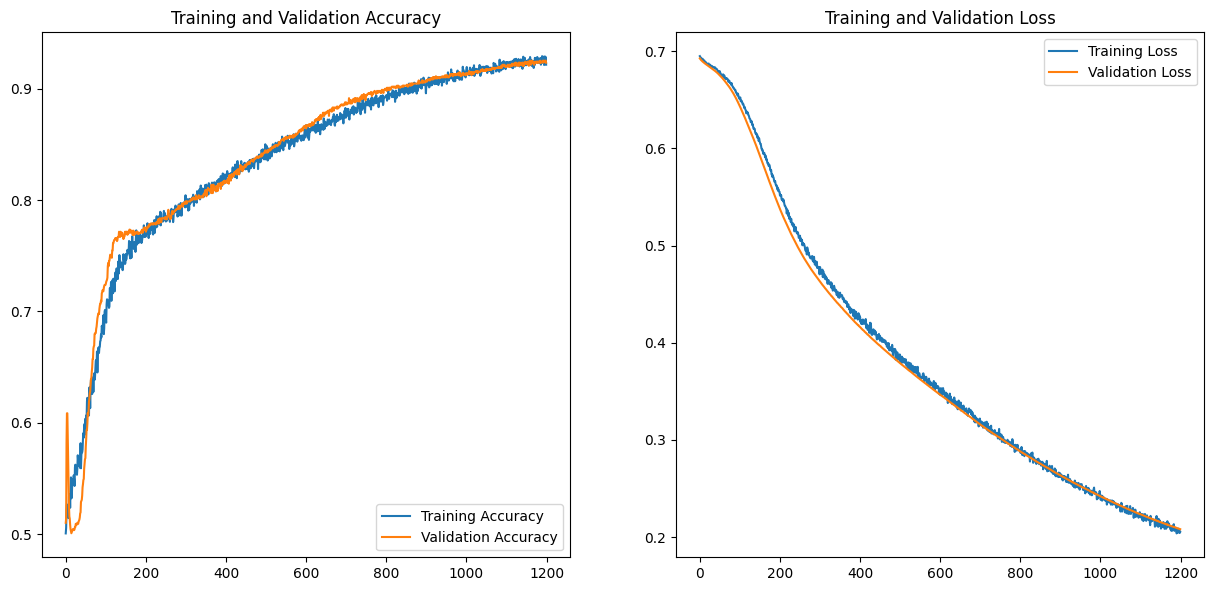

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1200)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [73]:
predictions = model.predict(x_val,steps=1,use_multiprocessing=True)
#predictions = predictions.reshape(1,-1)[0]
pred_y=np.argmax(predictions,axis=1)
print(classification_report(y_val, pred_y, target_names = ['Open (Class 0)','Closed (Class 1)']))

1/1 [==============================] - 0s 13ms/step
                  precision    recall  f1-score   support

  Open (Class 0)       0.92      0.93      0.92       543
Closed (Class 1)       0.93      0.92      0.92       525

        accuracy                           0.92      1068
       macro avg       0.92      0.92      0.92      1068
    weighted avg       0.92      0.92      0.92      1068



Test Model

In [74]:
def get_both_eyes(frame):
    left_eye_classifier = cv2.CascadeClassifier('/tf/zhijie07147/Smile_Detection_Train/cv2_data/haarcascades/haarcascade_lefteye_2splits.xml')
    right_eye_classifier =cv2.CascadeClassifier('/tf/zhijie07147/Smile_Detection_Train/cv2_data/haarcascades/haarcascade_righteye_2splits.xml')
    
    eye_left = None
    eye_right = None
    
    left_eye = left_eye_classifier.detectMultiScale(frame)
    for (ex,ey,ew,eh) in left_eye:
        eye_left = frame[ey: ey + eh, ex: ex + ew]
    
    right_eye = right_eye_classifier.detectMultiScale(frame)
    for (ex,ey,ew,eh) in right_eye:
        eye_right = frame[ey: ey + eh, ex: ex + ew]
    
    return eye_left,eye_right

In [75]:
# Asian man
img_asian = cv2.imread('asian_guy.jpg')[...,::-1]
# White man
img_white = cv2.imread('white_man.jpg')[...,::-1]

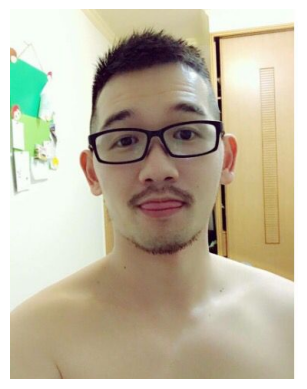

In [76]:
plt.axis('off')
plt.imshow(img_asian)

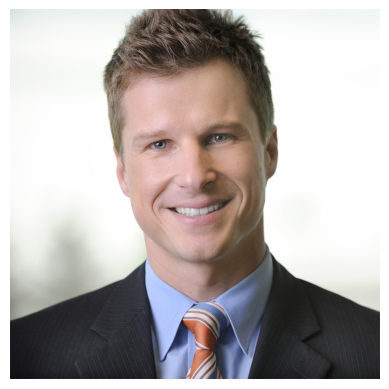

In [77]:
plt.axis('off')
plt.imshow(img_white)

In [78]:
# saving and loading the .h5 model
 
# save model
model.save('blink_model.h5')
print('Model Saved!')

Model Saved!


In [79]:
# load model
savedModel=load_model('blink_model.h5')
savedModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

In [101]:
def predict_eyes(eye_list):
    result = []
    for x in eye_list:
        x = cv2.resize(x,(24,24))
        x = cv2.cvtColor(x,cv2.COLOR_RGB2GRAY)
        x = np.repeat(np.expand_dims(x, axis=2), 3, axis=2)
        x = np.expand_dims(x, 0)
        detect = savedModel.predict(x,steps=1,use_multiprocessing=True,verbose=0)[0][1] 
        # output [[open,closed]] [0][1] == 1 would be closed
        result.append(int(detect))
    if (result == np.array([1, 1])).all(): return 1
    else: return 0

In [98]:
img_white_close = cv2.imread('white_woman_close.jpg')[...,::-1]

In [108]:
eyes = get_both_eyes(img_white_close)

In [109]:
predict_eyes(eyes)

1

In [99]:
# video
cap = cv2.VideoCapture("smile.mp4")

# webcam
#cap = cv2.VideoCapture(0)


# Put the code in try-except statements
# Catch the keyboard exception and 
# release the camera device and 
# continue with the rest of code.
try:
    # Check if the webcam is opened correctly
    if not cap.isOpened():
        raise IOError("Cannot open webcam")
    
    while(True):
        ret, frame = cap.read()

        if not ret:
            print("Released Video Resource")
            break
        
        
        blink_result = predict_eyes(get_both_eyes(frame))
        
        ### Codes for showing frame
        # Turn off the axis
        plt.axis('off')
        # Title of the window
        plt.title(smile_result)
        # Display the frame
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.show()
        # Display the frame until new frame is available
        # Overwrite the old graph
        clear_output(wait=True)

# If stop button are clicked
except KeyboardInterrupt:
    # Release the Video Device
    cap.release()
    # Message to be displayed after releasing the device
    print("Released Video Resource")

Released Video Resource
